# **Early prediction of neuroblastoma using miRNA expression data**
### ***KuNGS fury team***

**Aim**
* learn to detect status for MYCN using qPCR data on miRNA expression


**Objectives:**
* perform exploratory data analysis
* normalize the Cq values
* proceed differential analysis of miRNA expression at two cases: MYCN status=0 & MYCN status=1
* learn models to predict the disease status from predicants (PCA, logistic regression etc.)

In [1]:
# Installing required libraries

!pip install pingouin -q
!pip install pca -q
!pip install shap -q

     |████████████████████████████████| 183 kB 5.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 48.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 564 kB 5.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg #for Mann-U
from pca import pca as pca_util #for PCA
sns.set(style="white")

#RandomForest
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

import shap

from matplotlib_venn import venn3

## **Step 1. EDA and Filtering the data**



In [ ]:
# data loading

data = pd.read_csv('neuroblastoma_raw.csv')

In [4]:
# first look at the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 434 entries, sample to hsa-mir-9star
dtypes: float64(430), int64(1), object(3)
memory usage: 322.2+ KB


In [5]:
# check the types of the variables

data.dtypes

sample            object
MYCN_status        int64
subset            object
subset2           object
hsa-let-7a       float64
                  ...   
hsa-mir-96       float64
hsa-mir-98       float64
hsa-mir-99a      float64
hsa-mir-99b      float64
hsa-mir-9star    float64
Length: 434, dtype: object

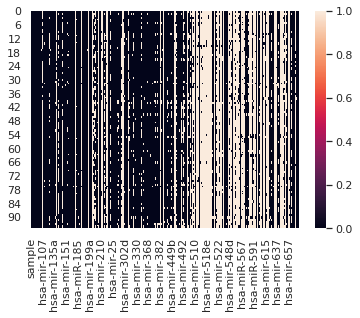

In [6]:
# check NA values

sns.heatmap(data.isnull())  # non-null values is in black color

#### Here we see some miRNAs that are filled with NA values in almost all samples.

#### Our goal is to filter our data and to remove miRNAs that are filled with NA in more than a half of the training samples (34). Also, if miRNA`s Cq is larger than 35, we assume this value as bad and shall replace it with NA.

In [7]:
data[data[data.columns[4:]] > 35]= np.nan
train_data = data[data['subset']=='Training'].reset_index(drop=True)
train_data = train_data.dropna(axis=1, thresh=train_data.shape[0] // 2)
train_data.head()

,sample,MYCN_status,subset,subset2,hsa-let-7a,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f,...,hsa-mir-660,hsa-mir-7,hsa-mir-9,hsa-mir-92,hsa-mir-93,hsa-mir-95,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,hsa-mir-9star
0,SAMPLE3,0,Training,Training,18.526676,16.622906,16.869097,20.686466,21.554474,21.380330,...,20.412485,14.820643,20.879412,14.799293,13.070967,20.020311,21.625270,16.251923,16.738031,22.982403
1,SAMPLE5,0,Training,Training,18.291204,17.499275,19.206512,21.529583,21.924965,21.557217,...,20.122952,15.583584,16.869104,15.276227,12.794785,19.749010,22.432873,16.911922,16.562393,20.157650
2,SAMPLE7,0,Training,Validation,17.129253,15.354254,16.722778,20.021446,22.345514,20.353985,...,19.451986,15.613646,19.160952,14.875856,14.050057,20.343788,22.888742,14.949352,17.382610,22.299150
3,SAMPLE8,0,Training,Validation,17.709484,16.184488,17.021826,20.678883,22.121305,20.916560,...,20.212801,15.639857,18.155730,15.048127,12.788982,19.558956,21.383392,16.004519,17.045906,21.477790
4,SAMPLE9,0,Training,Training,19.411581,17.645666,16.823164,22.268425,21.549550,22.093159,...,20.795620,14.635577,17.219072,15.423118,13.507247,19.323166,23.062310,16.392101,16.671783,20.130852


In [8]:
test_data = data.query("subset == 'Testing'").reset_index(drop=True)

## **Step 2. Data normalization**

Three different approaches to normalize the dataset were used to compare normalization: 
* normalization by mean Cq of all miRNA
* normalization by mean of one housekeeping miRNA gene
* normalization by mean of three housekeeping miRNA genes

## Normalization by mean Cq of all miRNA



### *Code*

---




In [9]:
normalized_data = train_data.copy()

sample_means = np.array(normalized_data[normalized_data.columns[4:]].mean(axis=1)).reshape(76,1)
normalized_data[normalized_data.columns[4:]] = normalized_data[normalized_data.columns[4:]] - sample_means

In [10]:
train_data_box=train_data.T
train_data_box.columns = train_data_box.iloc[0]
train_data_box=train_data_box.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)
train_data_box[train_data_box.columns[4:14]]

norm_data_box=normalized_data.T
norm_data_box.columns = norm_data_box.iloc[0]
norm_data_box=norm_data_box.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)
norm_data_box.sample(5)

sample,SAMPLE3,SAMPLE5,SAMPLE7,SAMPLE8,SAMPLE9,SAMPLE10,SAMPLE11,SAMPLE12,SAMPLE14,SAMPLE15,...,SAMPLE83,SAMPLE84,SAMPLE85,SAMPLE86,SAMPLE87,SAMPLE88,SAMPLE89,SAMPLE90,SAMPLE91,SAMPLE94
hsa-mir-601,4.467224,4.340993,4.47034,4.744921,4.561653,4.874907,3.359917,2.92696,5.896198,3.970235,...,5.154513,4.633583,4.373687,5.306303,4.202144,4.986823,6.017924,6.835168,7.657586,4.225359
hsa-mir-103,-4.463062,-4.971705,-4.159195,-4.397672,-4.666712,-4.847516,-3.475741,-2.816599,-4.846024,-3.25532,...,-4.030927,-4.534723,-4.531003,-4.792275,-4.126222,-3.410483,-4.036409,-4.174445,-3.481051,-4.98374
hsa-mir-181d,-3.671854,-3.754981,-3.601599,-3.587812,-4.37352,-3.907946,-4.639649,-4.389423,-3.491589,-2.806403,...,-3.549094,-3.632145,-3.856324,-4.042269,-2.625867,-3.027217,-3.930082,-2.937969,-2.726154,-4.16685
hsa-mir-375,-6.837737,-3.93478,-4.35168,-4.865317,-7.110475,-3.307773,-3.153377,0.10198,-6.696239,-8.288449,...,-4.236895,-4.288285,-4.328687,-8.692377,-6.63725,-5.564328,-3.653391,1.2279,-2.430321,-6.646154
hsa-miR-146b,-6.509864,-4.513471,-7.631986,-5.262557,-4.517154,-4.515931,-5.286489,-8.022714,-5.843729,-7.372823,...,-4.425352,-4.002993,-4.730917,-3.88491,-3.857268,-5.048208,-4.403311,-2.098068,-5.119593,-5.019301


In [12]:
def make_normalization_plot(df, title):
    plt.rcParams['font.size'] = 9
    plt.title(title, fontdict={'fontsize': 30})
    plt.xticks(rotation = 90)
    sns.boxplot(data=df[df.columns[4:54]])
    plt.savefig(title.replace(' ', '_') + '.png')

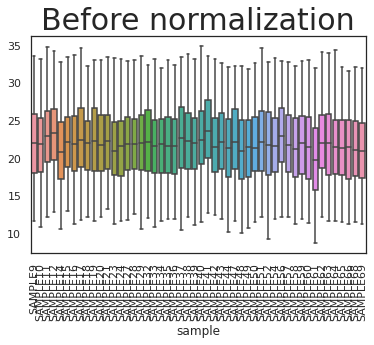

In [13]:
make_normalization_plot(train_data_box, 'Before normalization')

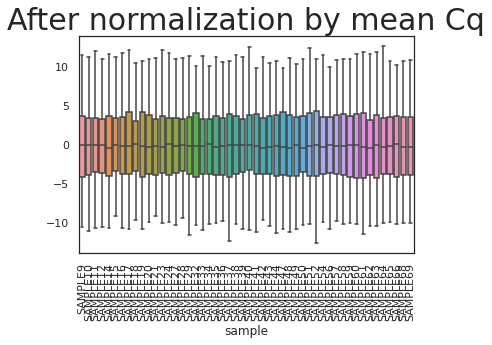

In [14]:
make_normalization_plot(norm_data_box, 'After normalization by mean Cq')

## Normalization by mean Cq of 3 housekeeping genes with NormiRazor

### Code

In [15]:
# preparing for normalization

neuro_norm_full = train_data.copy()
neuro_norm_full = neuro_norm_full.set_index('sample')
neuro_norm_full = neuro_norm_full.T
neuro_norm = neuro_norm_full.drop(index=['MYCN_status', 'subset', 'subset2'])
neuro_norm.to_csv('Neuro_norm.csv', header = True)

# neuro_norm goes to NormiRazor

In [16]:
# recreate dataset after normalization

neuro_razor_norm = pd.read_csv('First_3.csv')
neuro_razor_norm.rename(columns={'NAME':'sample'}, inplace=True)
neuro_razor_norm.set_index('sample', inplace=True)
neuro_razor_norm_full = pd.concat([neuro_norm_full.loc[['MYCN_status', 'subset', 'subset2']], neuro_razor_norm])
neuro_razor_norm_full.head()

,SAMPLE3,SAMPLE5,SAMPLE7,SAMPLE8,SAMPLE9,SAMPLE10,SAMPLE11,SAMPLE12,SAMPLE14,SAMPLE15,...,SAMPLE83,SAMPLE84,SAMPLE85,SAMPLE86,SAMPLE87,SAMPLE88,SAMPLE89,SAMPLE90,SAMPLE91,SAMPLE94
MYCN_status,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
subset,Training,Training,Training,Training,Training,Training,Training,Training,Training,Training,...,Training,Training,Training,Training,Training,Training,Training,Training,Training,Training
subset2,Training,Training,Validation,Validation,Training,Training,Validation,Training,Validation,Training,...,Training,Training,Training,Validation,Validation,Training,Training,Training,Training,Validation
hsa-let-7a,0.507345,0.235939,-1.129154,-0.677674,1.308655,0.481445,-1.216263,-1.573112,-0.117943,-1.036096,...,0.473647,0.318423,0.672726,0.347971,0.896598,-0.323899,-0.76577,-2.334547,-0.406482,-0.262016
hsa-let-7b,-1.396425,-0.55599,-2.904153,-2.20267,-0.45726,-0.888515,-2.953471,-3.840993,-1.370649,-2.601883,...,-0.005832,0.143245,-0.238836,-0.24922,0.813966,-1.986102,-0.97093,-3.10667,-2.268171,-0.559118


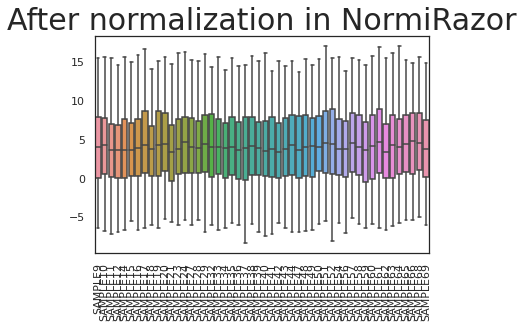

In [17]:
make_normalization_plot(df=neuro_razor_norm, title='After normalization in NormiRazor')

## Normalization by hsa-mir-16

### *Code*

In [18]:
normalized_data_mir16 = train_data.copy()
normalized_data_mir16 = normalized_data_mir16.set_index('sample')
mir16 = np.array(normalized_data_mir16['hsa-mir-16'])

normalized_data_mir16[normalized_data_mir16.columns[4:]] = normalized_data_mir16[normalized_data_mir16.columns[4:]].apply(lambda x : x - mir16)
normalized_data_mir16 = normalized_data_mir16.drop(columns=['MYCN_status', 'subset', 'subset2'])
normalized_data_mir16_T = normalized_data_mir16.T
normalized_data_mir16_T.head()

sample,SAMPLE3,SAMPLE5,SAMPLE7,SAMPLE8,SAMPLE9,SAMPLE10,SAMPLE11,SAMPLE12,SAMPLE14,SAMPLE15,...,SAMPLE83,SAMPLE84,SAMPLE85,SAMPLE86,SAMPLE87,SAMPLE88,SAMPLE89,SAMPLE90,SAMPLE91,SAMPLE94
hsa-let-7a,18.526676,18.291204,17.129253,17.709484,19.411581,18.213943,18.145796,18.189089,17.103165,17.516312,...,17.790024,17.973682,18.505323,17.301035,20.038507,17.139982,16.073090,13.140298,22.873867,18.493538
hsa-let-7b,1.891168,2.954393,0.996854,0.865933,2.859113,2.740208,0.621196,-0.887388,1.850316,1.134319,...,2.819696,3.219760,2.942278,2.850835,4.690496,0.360426,1.367808,-0.643763,-1.161854,3.728993
hsa-let-7c,2.137359,4.661630,2.365378,1.703271,2.036611,4.743116,0.887256,0.025312,4.318569,2.411293,...,4.401011,5.367885,4.765011,4.333071,6.443624,1.228387,3.311775,1.535890,1.142718,5.835838
hsa-let-7d,5.954728,6.984701,5.664046,5.360328,7.481872,6.963791,5.915886,4.999260,6.838850,5.722750,...,5.903738,5.377664,5.706622,5.938987,6.495754,4.257649,4.437468,4.051638,2.232470,6.641140
hsa-let-7e,6.822736,7.380083,7.988114,6.802750,6.762997,7.499090,7.765048,7.525997,6.804140,7.243145,...,5.826360,5.932021,6.435265,6.204953,7.764351,5.869004,5.330870,5.675448,5.646398,7.760794


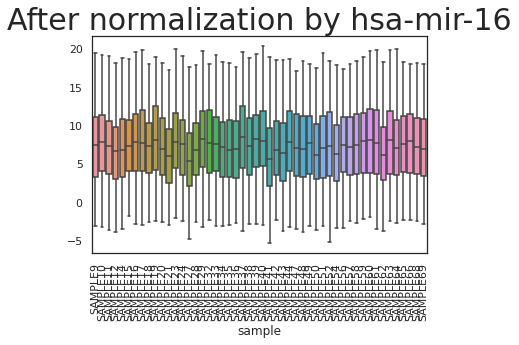

In [19]:
make_normalization_plot(df=normalized_data_mir16_T, title='After normalization by hsa-mir-16')

According to the results of three normalization approaches, miRNA-16 seems to be unsuitable for normalization. Normalization by mean Cq appeared to be the most relevant but NormiRazor normalization also looks good. For the next step we chose those two normalized datasets.

## **Step 3. Mann-Whitney test**




In [20]:
def mw_test(df, grouping, groups, index_list, correction):
    '''grouping - a variable for grouping
      groups - values of grouping variable
      index_list - list of miRNAs
      correction - type of correction to use (fdr-bh, bonf)'''

    mw_stats = pd.DataFrame(columns=['statistic', 'tail', 'pvalue', 'RBC', 'CLES'],
                        index=index_list)
    
    for column in index_list:
        l1 = df.query(''.join('{} == {}'.format(grouping, groups[0])))[column].astype('float64') 
        l2 = df.query(''.join('{} == {}'.format(grouping, groups[1])))[column].astype('float64')
        stats = pg.mwu(l1, l2, alternative = 'two-sided')
        mw_stats.loc[column] = stats.values[0]

    mw_stats['corrected_pvalue'] = pg.multicomp(mw_stats.pvalue.to_list(), method=correction)[1]

    return mw_stats

## Mann-Whitney test for normalized data on 3 house-keeping genes by NormiRazor

In [21]:
mw_razor = neuro_razor_norm_full.T

In [22]:
# Mann-Whitney test with Benjamini-Hochberg correction

mw_razor_result = mw_test(df=mw_razor, grouping='MYCN_status', groups=[0, 1], index_list=mw_razor.columns[3:], correction='fdr_bh')

In [23]:
# Differences without correction

mw_razor_result.query("pvalue < 0.05").shape[0]

133

In [24]:
# differences with FDR correction

mw_razor_result.query("corrected_pvalue < 0.05").shape[0]

109

In [25]:
# differences vizualization

def differences_vizualization(feature, title):
    '''feature - pandas series - pvalue or corrected_pvalue'''

    sns.displot(feature.astype(np.float64), kde=True, bins=11)
    plt.grid()
    plt.title(title)
    plt.savefig(title.replace(' ', '_') + '.png')

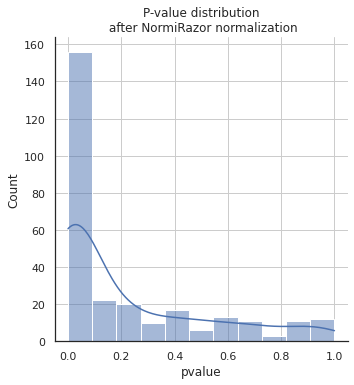

In [26]:
differences_vizualization(mw_razor_result.pvalue, "P-value distribution\n after NormiRazor normalization")

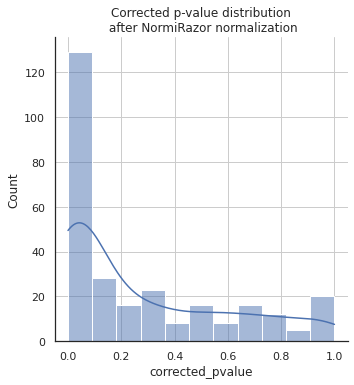

In [27]:
differences_vizualization(mw_razor_result.corrected_pvalue, "Corrected p-value distribution\n after NormiRazor normalization")

In [28]:
# Mann-Whitney test with Bonferroni correction

mw_razor_result_bf = mw_test(df=mw_razor, grouping='MYCN_status', groups=[0, 1], index_list=mw_razor.columns[3:], correction='bonf')

In [29]:
# differences with Bonferroni correction

mw_razor_result_bf.query("corrected_pvalue < 0.05").shape[0]

27

In [30]:
razor = mw_razor_result_bf.query("corrected_pvalue < 0.05").index.to_list()

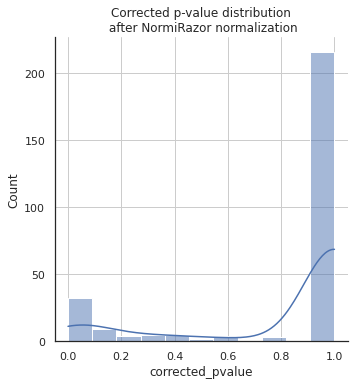

In [31]:
differences_vizualization(mw_razor_result_bf.corrected_pvalue, "Corrected p-value distribution\n after NormiRazor normalization")

## Mann-Whitney test for normalized data by mean Cq

In [32]:
mw_mean = norm_data_box.copy()
mw_mean_with_status = pd.concat([neuro_norm_full.loc[['MYCN_status']], mw_mean])
mw_mean = mw_mean_with_status.T
mw_mean.head(5)

,MYCN_status,hsa-let-7a,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-mir-1,...,hsa-mir-660,hsa-mir-7,hsa-mir-9,hsa-mir-92,hsa-mir-93,hsa-mir-95,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,hsa-mir-9star
sample,,,,,,,,,,,,,,,,,,,,,
SAMPLE3,0,-3.62928,-5.53305,-5.286859,-1.46949,-0.601482,-0.775626,-2.626713,-2.515743,6.747153,...,-1.743471,-7.335313,-1.276544,-7.356662,-9.084989,-2.135645,-0.530686,-5.904033,-5.417925,0.826447
SAMPLE5,0,-4.089416,-4.881345,-3.174108,-0.851037,-0.455655,-0.823403,-1.981221,-1.818164,4.369073,...,-2.257668,-6.797036,-5.511516,-7.104393,-9.585835,-2.63161,0.052253,-5.468698,-5.818227,-2.22297
SAMPLE7,0,-4.942227,-6.717226,-5.348702,-2.050034,0.274034,-1.717495,-3.196728,-2.697315,4.341814,...,-2.619494,-6.457833,-2.910528,-7.195624,-8.021423,-1.727692,0.817262,-7.122128,-4.68887,0.22767
SAMPLE8,0,-4.423303,-5.948299,-5.110961,-1.453904,-0.011482,-1.216227,-2.502587,-2.335082,4.615697,...,-1.919986,-6.49293,-3.977057,-7.08466,-9.343805,-2.573831,-0.749395,-6.128268,-5.086881,-0.654997
SAMPLE9,0,-2.772413,-4.538328,-5.36083,0.084431,-0.634444,-0.090835,-1.080915,-0.691259,4.444116,...,-1.388374,-7.548417,-4.964922,-6.760876,-8.676747,-2.860828,0.878316,-5.791893,-5.512211,-2.053142


In [33]:
# Mann-Whitney test with Benjamini-Hochberg correction

mw_mean_result = mw_test(df=mw_mean, grouping='MYCN_status', groups=[0, 1], index_list=mw_mean.columns[1:], correction='fdr_bh')

In [34]:
# Differences without correction

mw_mean_result.query("pvalue < 0.05").shape[0]

135

In [35]:
# differences with FDR correction

mw_mean_result.query("corrected_pvalue < 0.05").shape[0]

112

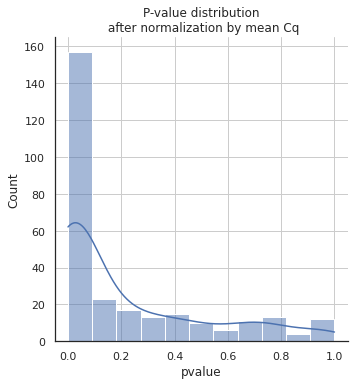

In [36]:
differences_vizualization(mw_mean_result.pvalue, "P-value distribution\n after normalization by mean Cq")

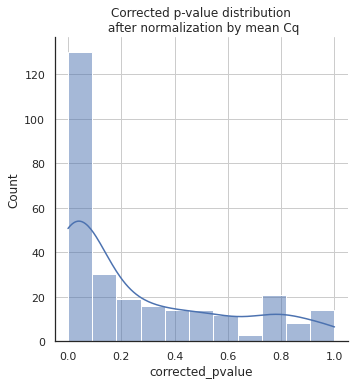

In [37]:
differences_vizualization(mw_mean_result.corrected_pvalue, "Corrected p-value distribution\n after normalization by mean Cq")

In [38]:
# Mann-Whitney test with Bonferroni correction

mw_mean_result_bf = mw_test(df=mw_mean, grouping='MYCN_status', groups=[0, 1], index_list=mw_mean.columns[1:], correction='bonf')

In [39]:
# differences with Bonferroni correction

mw_mean_result_bf.query("corrected_pvalue < 0.05").shape[0]

30

In [40]:
meancq = mw_mean_result_bf.query("corrected_pvalue < 0.05").index.to_list()

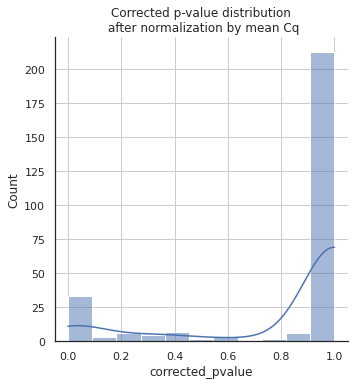

In [41]:
differences_vizualization(mw_mean_result_bf.corrected_pvalue, "Corrected p-value distribution\n after normalization by mean Cq")

With less strict Benjamini-Hochberg correction we have got too many differentially expressed miRNAs, so Bonferroni correction was performed. This gave us 27 miRNAs for NormiRazor-normalized data and 30 miRNAs for mean Cq-normalized data.

In [42]:
# miRNAs from Limma

limma_set = pd.read_csv('DEG_miRNA.csv')
limma = limma_set.labels.to_list()
len(limma)

32

After differential expression analysis in Limma program with the data normalized by mean Cq we got 32 genes, so we decided to use this largest set of genes for machine learning.

Venne diagramm below visualizes how sets of genes, obtained by different approaches, are intersected (and they are intersected quite well).

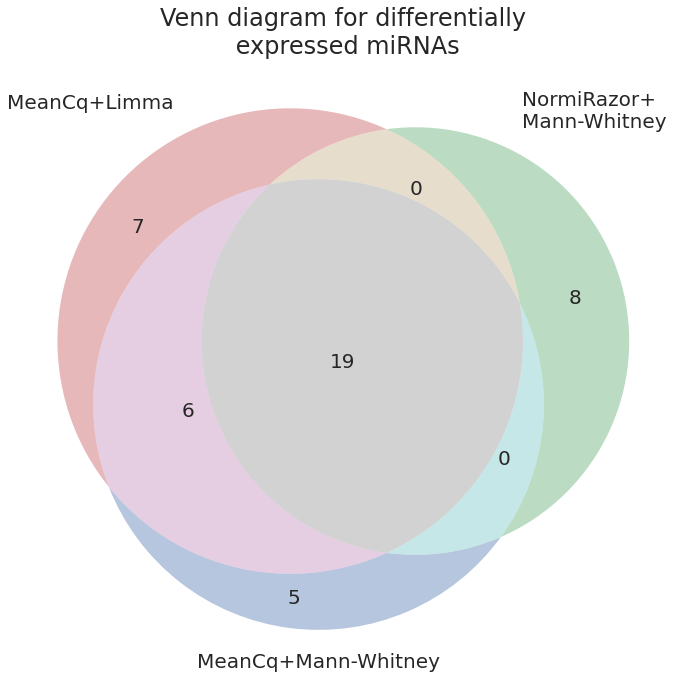

In [43]:
A = set(limma)
B = set(razor)
C = set(meancq)

plt.figure(figsize=(12, 12))
diagram = venn3([A, B, C], ("MeanCq+Limma", "NormiRazor+\nMann-Whitney", "MeanCq+Mann-Whitney"))

for text in diagram.set_labels:
    text.set_fontsize(20)
for text in diagram.subset_labels:
    text.set_fontsize(20)
plt.title('Venn diagram for differentially\n expressed miRNAs', fontsize=24)
plt.savefig('Venn.png')


## **Step 4. LPCA**

To visualize separation of groups and the miRNAs, that contribute to data variability most, we performed principal component analysis with 32 differentially expressed genes after Limma.

In [44]:
train_dataset = normalized_data.copy()
train_dataset = pd.concat([train_dataset.iloc[:, 0:4], train_dataset[limma]], axis=1)
train_dataset = train_dataset.fillna(0)

In [45]:
model_neuro = pca_util(n_components=0.63)
out_neuro = model_neuro.fit_transform(train_dataset.iloc[:, 4:])

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [63.0%] explained variance using the [32] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [63.00%] explained variance.
[pca] >The PCA reduction is performed on the [32] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


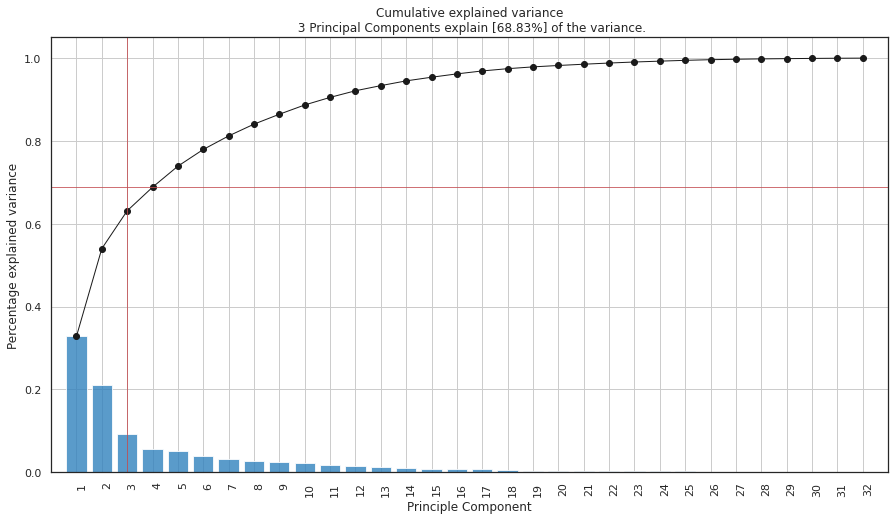

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d298f3810>)

<Figure size 432x288 with 0 Axes>

In [46]:
model_neuro.plot(figsize=(15, 8))

[pca] >Plot PC1 vs PC2 with loadings.


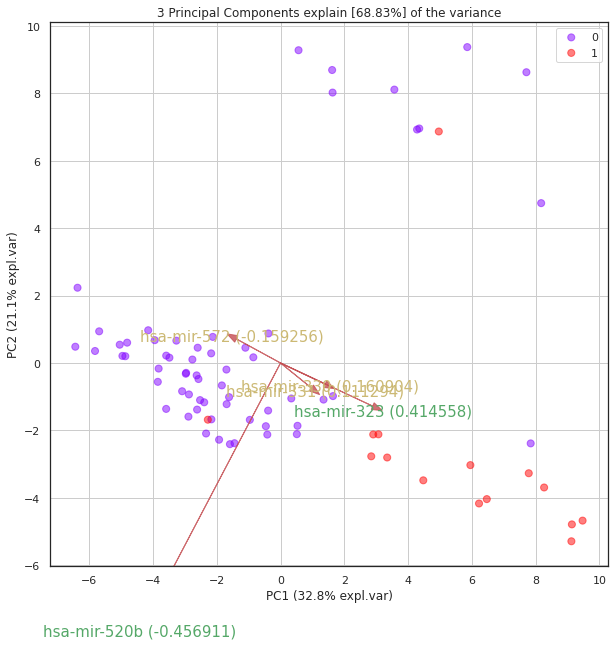

In [49]:
to_point_diag_neuro = out_neuro['PC']
to_point_diag_neuro['MYCN_status'] = train_dataset.MYCN_status.values

plt.rcParams['font.size'] = 15
out_graph = model_neuro.biplot(legend=True, figsize=(10, 10),
             y=train_dataset.MYCN_status.values,  cmap ='rainbow', n_feat=5, d3=False, label=False, alpha_transparency = 0.5)


## **Step 5. RandomForest classifier**

Random Forest Classifier fits several decision tree classifiers using the sub-sampling of a dataset and averaging the results to improve accuracy and control over-fitting.

In [50]:
def random_forest_clf(X_func, y_func):

  classifier = RandomForestClassifier(random_state=60)

  parametrs = {'n_estimators':np.arange(start=10, stop=40, step=5),
              'max_depth': np.arange(start=1, stop=6, step=2),
              'min_samples_leaf':np.arange(start=1, stop=8, step=2),
              'min_samples_split':np.arange(start=2, stop=10, step=2)}

  grid_search = GridSearchCV(classifier, parametrs, cv=4)

  grid_search.fit(X_func, y_func)


  return grid_search.best_estimator_

Firstly, train and test data were prepaired - only miRNAs from limma list of differentially expressed genes were kept.

In [51]:
deg_genes = pd.read_csv('DEG_miRNA.csv', index_col=0)
cols_deg = list(deg_genes.index)
cols_deg.append('MYCN_status')

In [52]:
train_dataset = train_data[train_data.columns.intersection(cols_deg)].fillna(0)
test_dataset = test_data[train_data.columns.intersection(cols_deg)].fillna(0)

In [53]:
X = train_dataset.drop(columns=['MYCN_status'])
y = pd.Series(train_dataset.MYCN_status)

X_real_test = test_dataset.drop(columns=['MYCN_status'])
y_real_test = pd.Series(test_dataset.MYCN_status)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [55]:
best_clf = random_forest_clf(X_train, y_train)

In [56]:
predict_real_test = best_clf.predict(X_real_test)
print(metrics.classification_report(y_real_test, predict_real_test))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.67      0.80      0.73         5

    accuracy                           0.84        19
   macro avg       0.79      0.83      0.81        19
weighted avg       0.86      0.84      0.85        19



In [57]:
best_clf_features_df = pd.DataFrame({"features":list(X),
                                    "importances":best_clf.feature_importances_})

features_sort = best_clf_features_df.sort_values("importances", ascending=False)

features_sort[features_sort.importances > 0]

,features,importances
18,hsa-mir-330,0.193829
19,hsa-mir-331,0.118520
31,hsa-mir-95,0.078600
30,hsa-mir-92,0.054462
17,hsa-mir-324-5p,0.052456
4,hsa-mir-152,0.052035
5,hsa-mir-153,0.049000
1,hsa-mir-148a,0.048020
10,hsa-mir-19a,0.042909
8,hsa-mir-188,0.042630


In [58]:
explainer = shap.TreeExplainer(best_clf)

Text(0.5, 1.0, 'The graph of the features importance ')

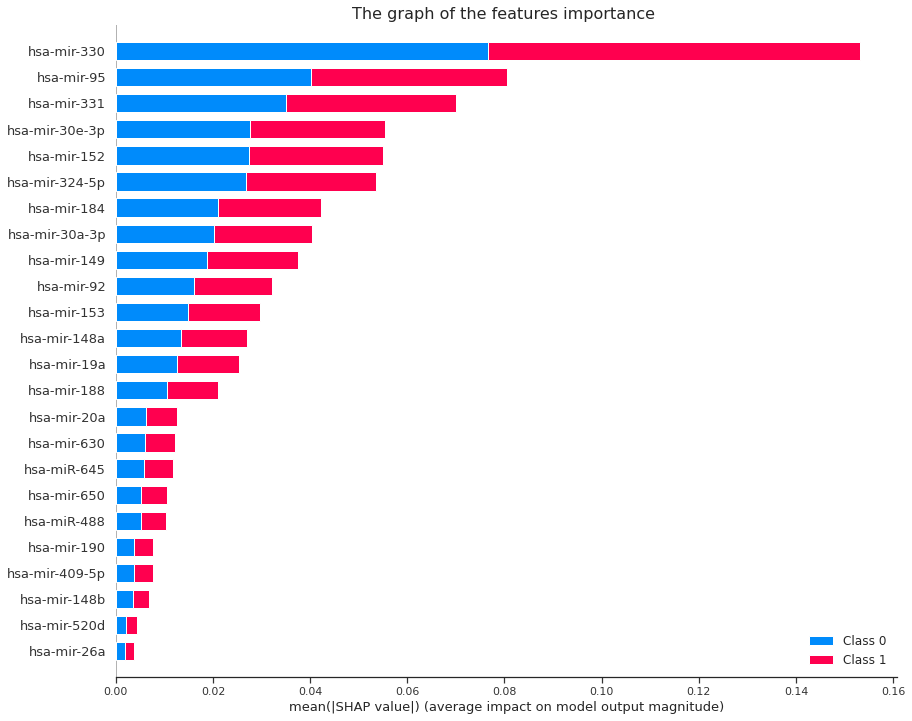

In [59]:
number_of_good_features = len(features_sort[features_sort.importances > 0])
shap_values = explainer.shap_values(X_real_test, check_additivity=False)
shap.summary_plot(shap_values, features = X_real_test, max_display=number_of_good_features, show=False)

fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_title('The graph of the features importance ', fontsize=16)

## **Step 6. Classification by K nearest neighbors method**

KNN method is based on calculating distances between new data points and groups that train data forms. This method was performed on 32 DEG from Limma.

(76, 33)


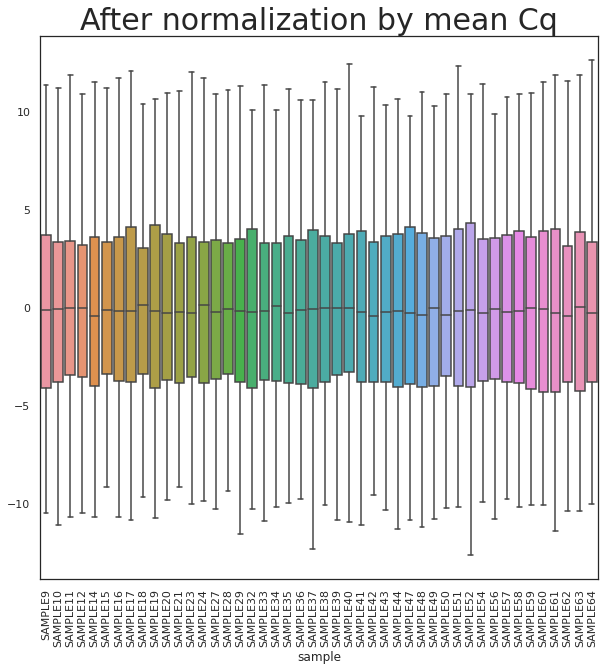

In [76]:
# normalization for train

normalized_data = train_data.copy()

sample_means = np.array(normalized_data[normalized_data.columns[4:]].mean(axis=1)).reshape(76,1)
normalized_data[normalized_data.columns[4:]] = normalized_data[normalized_data.columns[4:]] - sample_means


train_data_box=train_data.T
train_data_box.columns = train_data_box.iloc[0]
train_data_box=train_data_box.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)
train_data_box[train_data_box.columns[4:14]]

norm_data_box=normalized_data.T
norm_data_box.columns = norm_data_box.iloc[0]
norm_data_box=norm_data_box.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)
norm_data_box.head()

plt.figure(figsize=(10, 10))
plt.title('After normalization by mean Cq', fontdict={'fontsize': 30})
plt.xticks(rotation = 90)
sns.boxplot(data=norm_data_box[norm_data_box.columns[4:50]])

train_norm = normalized_data[normalized_data.columns.intersection(cols_deg)]
print(train_norm.shape)

(19, 33)


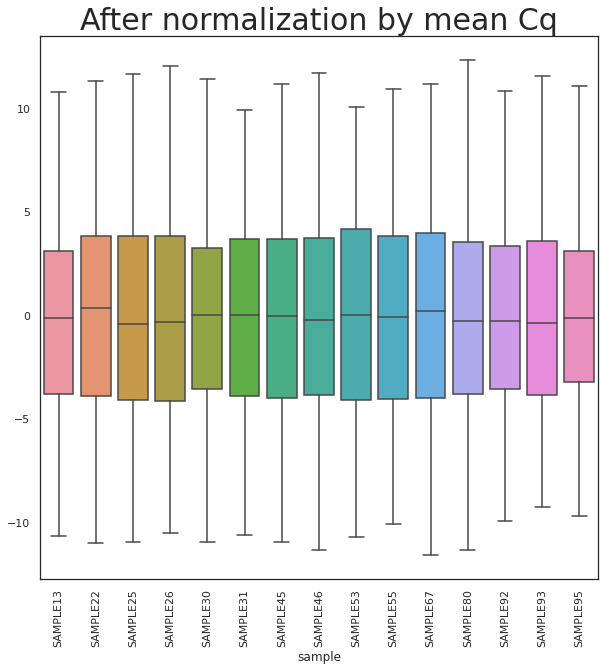

In [77]:
# normalization for test

normalized_data_test = test_data.copy()

sample_means_test = np.array(normalized_data_test[normalized_data_test.columns[4:]].mean(axis=1)).reshape(19,1)
normalized_data_test[normalized_data_test.columns[4:]] = normalized_data_test[normalized_data_test.columns[4:]] - sample_means_test


test_data_box=test_data.T
test_data_box.columns = test_data_box.iloc[0]
test_data_box=test_data_box.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)
test_data_box[test_data_box.columns[4:14]]

norm_data_box_test=normalized_data_test.T
norm_data_box_test.columns = norm_data_box_test.iloc[0]
norm_data_box_test=norm_data_box_test.drop(['subset', 'subset2', 'MYCN_status', 'sample'], axis=0)

plt.figure(figsize=(10, 10))
plt.title('After normalization by mean Cq', fontdict={'fontsize': 30})
plt.xticks(rotation = 90)
sns.boxplot(data=norm_data_box_test[norm_data_box_test.columns[4:50]])

test_norm = normalized_data_test[normalized_data_test.columns.intersection(cols_deg)]
print(test_norm.shape)

In [78]:
#  KNN for train_norm, test_norm

# prepare train dataset

X_train = train_norm.copy()
X_train.fillna(0, inplace=True)
X_train.drop(columns=['MYCN_status'], inplace=True)
y_train = pd.DataFrame(train_norm['MYCN_status'])
y_train

,MYCN_status
0,0
1,0
2,0
3,0
4,0
...,...
71,0
72,0
73,0
74,0


In [79]:
# prepare test dataset

X_test = test_norm.copy()
X_test.fillna(0, inplace=True)
X_test.drop(columns=['MYCN_status'], inplace=True)
y_test = pd.DataFrame(test_norm['MYCN_status'])

In [80]:
# find the best model with gridSearchCV

grid_params = {'n_neighbors': range(1, 10),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'manhattan']}

gridsearch = GridSearchCV(KNeighborsClassifier(),
                          grid_params, 
                          verbose=1, 
                          cv=5, 
                          n_jobs=-1)
gs_result = gridsearch.fit(X_train, y_train)
best_knn = gs_result.best_estimator_
print('best_score=', gs_result.best_score_,
      'best_estimator=', gs_result.best_estimator_)
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
best_score= 0.9349999999999999 best_estimator= KNeighborsClassifier(metric='manhattan', n_neighbors=6, weights='distance')
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.80      0.80      0.80         5

    accuracy                           0.89        19
   macro avg       0.86      0.86      0.86        19
weighted avg       0.89      0.89      0.89        19



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
